# Geolocalización De Municipios

/Users/Daniel/Library/Python/3.9/lib/python/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/8b/d34q145x44x2xf_06_gchyfw0000gq/T/ipykernel_70763/269877476.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn')  # Rojo para negativo, verde para positivo


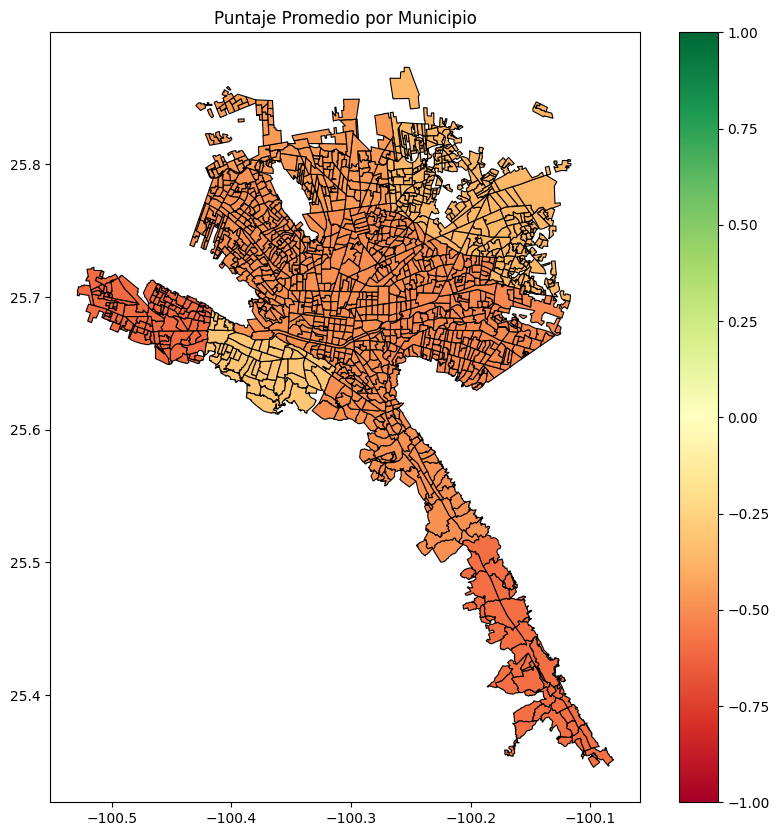

In [186]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize

# Carga del archivo SHP
shapefile_path2 = "2023_1_19_A/2023_1_19_A.shp"  
gdf2 = gpd.read_file(shapefile_path2)

# Definir los valores de CVE_MUN que corresponden a los municipios
cve_mun_values = {
    '006': 'Apodaca', 
    '019': 'San Pedro Garza García', 
    '021': 'Escobedo', 
    '026': 'Guadalupe', 
    '039': 'Monterrey', 
    '046': 'San Nicolás', 
    '048': 'Santa Catarina', 
    '049': 'Santiago'
}

# Filtra el GeoDataFrame por los valores de CVE_MUN
gdf2_delimited = gdf2[gdf2['CVE_MUN'].isin(cve_mun_values.keys())]

# Cargar el DataFrame con los puntajes
df = pd.read_csv('df_con_entidades.csv')

# Lista de entidades (municipios) preseleccionadas
entidades_preseleccionadas = list(cve_mun_values.values())

# Función para filtrar las filas que contengan al menos una de las entidades preseleccionadas
def filtrar_filas_por_entidades(df, entidades):
    entidades = [e.lower() for e in entidades]
    filas_filtradas = df[df['entidades'].apply(
        lambda x: any(entidad in entidad_lista.lower() for entidad in entidades for entidad_lista in eval(x))
        if x != '[]' else False  # Evitar listas vacías
    )]
    return filas_filtradas

# Filtramos las filas por entidades preseleccionadas
filas_filtradas = filtrar_filas_por_entidades(df, entidades_preseleccionadas)

# Calcular el puntaje promedio por municipio
promedio_puntajes = {}
for municipio in entidades_preseleccionadas:
    filas_municipio = filas_filtradas[filas_filtradas['entidades'].apply(
        lambda x: municipio.lower() in [entidad.lower() for entidad in eval(x)])]
    if not filas_municipio.empty:
        promedio_puntajes[municipio] = np.mean(filas_municipio['Puntaje'])
    else:
        promedio_puntajes[municipio] = None

# Asignar los puntajes promedios a los códigos CVE_MUN correspondientes
gdf2_delimited['Puntaje'] = gdf2_delimited['CVE_MUN'].map({cve: promedio_puntajes[mun] for cve, mun in cve_mun_values.items()})

# Configurar el colormap (escala de colores) para que los valores negativos sean rojos y los positivos verdes
norm = Normalize(vmin=-1, vmax=1)
cmap = cm.get_cmap('RdYlGn')  # Rojo para negativo, verde para positivo

# Graficar el GeoDataFrame con los colores basados en el puntaje
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf2_delimited.plot(column='Puntaje', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='black', legend=True, norm=norm)

# Añadir título y mostrar el gráfico
plt.title('Puntaje Promedio por Municipio')
plt.show()

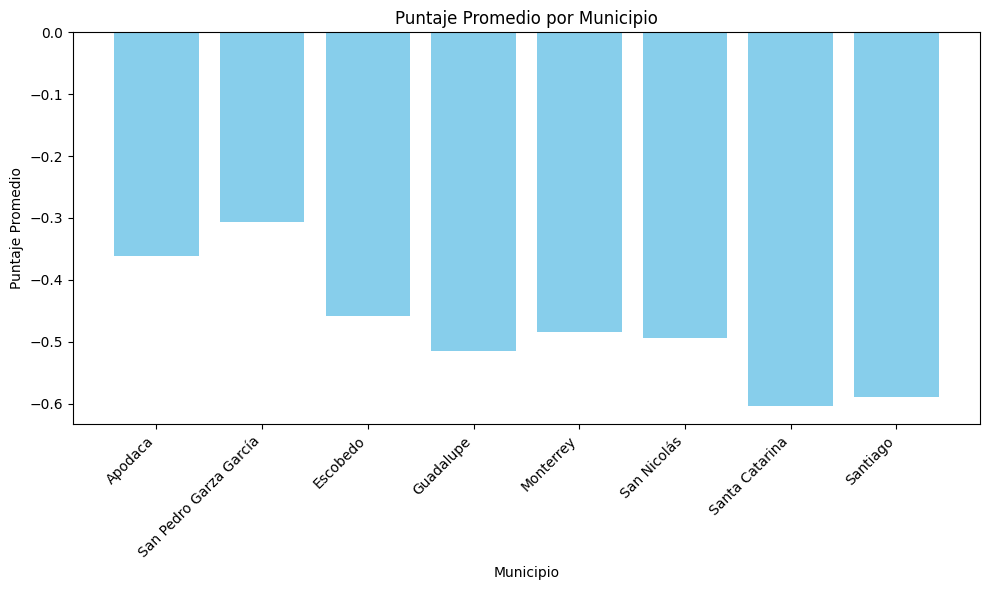

In [50]:
# Filtrar los puntajes que no son None
puntajes_validos = {municipio: puntaje for municipio, puntaje in promedio_puntajes.items() if puntaje is not None}

# Generar el histograma
plt.figure(figsize=(10, 6))
plt.bar(puntajes_validos.keys(), puntajes_validos.values(), color='skyblue')
plt.xlabel('Municipio')
plt.ylabel('Puntaje Promedio')
plt.title('Puntaje Promedio por Municipio')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Ajusta el layout para evitar que las etiquetas se corten
plt.show()


# Geolocalización de colonias

/var/folders/8b/d34q145x44x2xf_06_gchyfw0000gq/T/ipykernel_70763/3197826905.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn')  # Rojo para negativo, verde para positivo


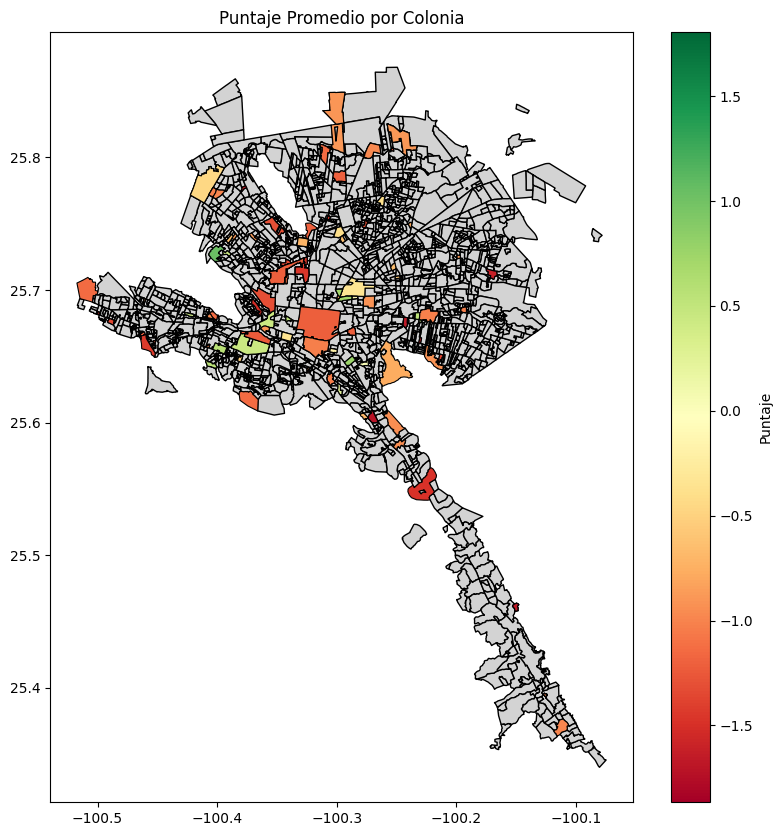

In [184]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

# Cargar el archivo shapefile
shapefile_path = "Colonias/Colonias.shp"  
gdf = gpd.read_file(shapefile_path)

# Cargar el archivo CSV con las colonias y puntajes
csv_path = "df_con_colonias.csv" 
df = pd.read_csv(csv_path)

# Convertir la columna 'colonia' a mayúsculas
df['colonia'] = df['colonia'].str.upper()

# Filtrar los municipios y el estado
municipios = ['APODACA', 'SAN PEDRO GARZA GARCÍA', 'GENERAL ESCOBEDO', 'GUADALUPE', 'MONTERREY', 'SAN NICOLÁS DE LOS GARZA', 'SANTA CATARINA', 'SANTIAGO']
gdf_filtered = gdf[(gdf['MUN_NAME'].isin(municipios)) & (gdf['ST_NAME'] == 'NUEVO LEON')]

# Hacer merge entre el shapefile y el CSV usando la columna de las colonias, pero conservando todas las colonias del shapefile
gdf_filtered = gdf_filtered.merge(df, left_on='SETT_NAME', right_on='colonia', how='left')

# Obtener el puntaje mínimo y máximo del dataset
vmin = df['Puntaje'].min()
vmax = df['Puntaje'].max()

# Configurar el colormap para que los valores negativos sean rojos y los positivos verdes, y normalizar con los puntajes mínimos y máximos
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap('RdYlGn')  # Rojo para negativo, verde para positivo

# Crear el mapa base con un color por defecto para las colonias sin datos (por ejemplo, azul claro)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Pintar primero las colonias sin puntaje con un color de fondo (ejemplo: azul claro)
gdf_filtered[gdf_filtered['Puntaje'].isna()].plot(ax=ax, color='lightgray', edgecolor='black')

# Luego pintar las colonias con puntaje usando el colormap
gdf_filtered[~gdf_filtered['Puntaje'].isna()].plot(column='Puntaje', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='black', norm=norm)

# Añadir la leyenda
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Crear una leyenda vacía para la colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Puntaje')

# Añadir título y mostrar el gráfico
plt.title('Puntaje Promedio por Colonia')
plt.show()


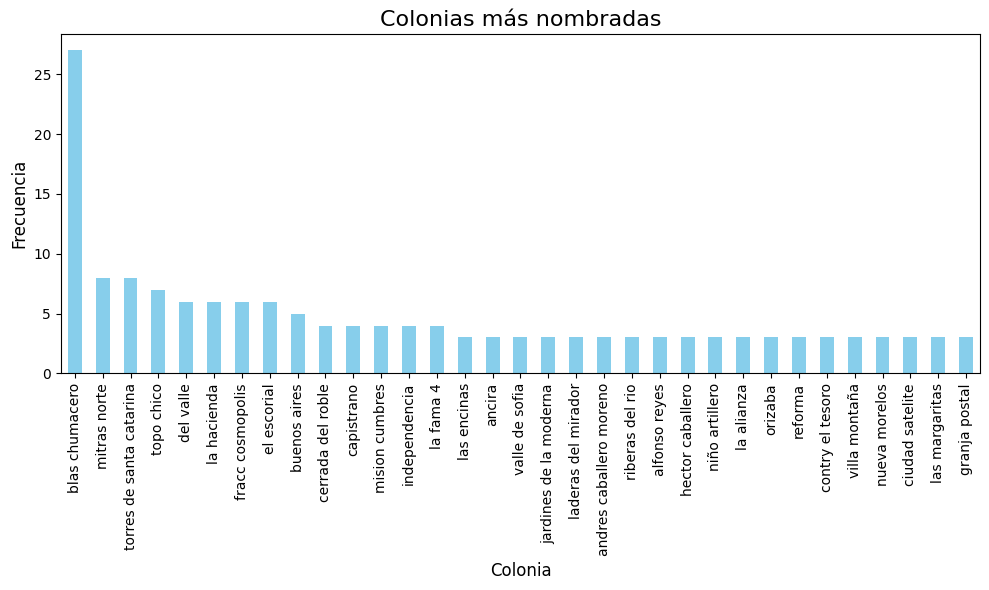

In [192]:
# Contar las frecuencias de cada colonia
frecuencias_colonias = colonias['colonia'].value_counts()

# Filtrar las colonias con frecuencia mayor o igual a 3
colonias_filtradas = frecuencias_colonias[frecuencias_colonias >= 3]

# Crear un histograma de las colonias filtradas
plt.figure(figsize=(10,6))
colonias_filtradas.plot(kind='bar', color='skyblue')

# Añadir etiquetas y título
plt.title('Colonias más nombradas', fontsize=16)
plt.xlabel('Colonia', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# Rotar las etiquetas en el eje X
plt.xticks(rotation=90)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

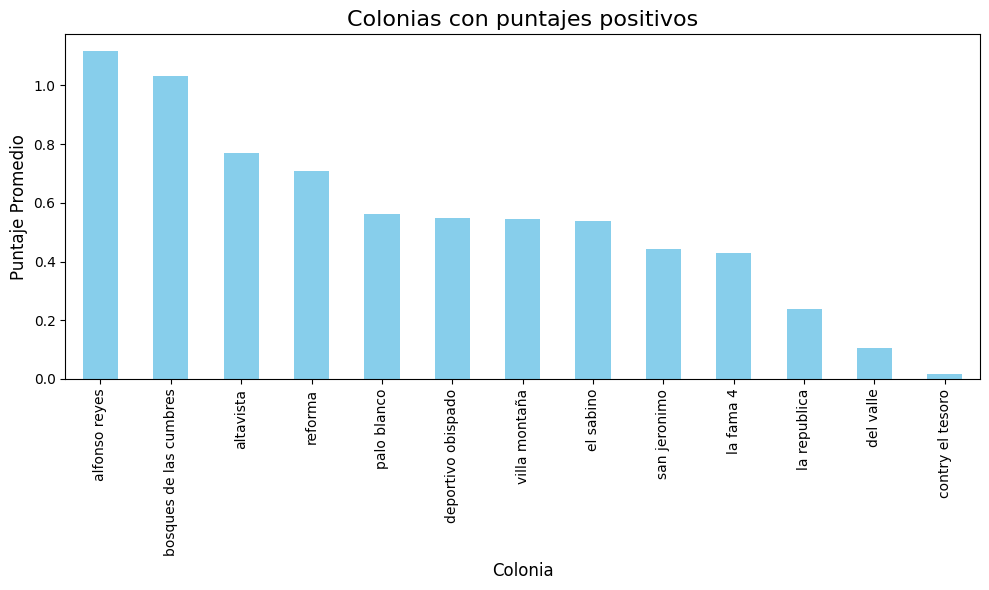

In [218]:
import matplotlib.pyplot as plt

# Agrupar por colonia y calcular el puntaje promedio para cada una
puntaje_por_colonia = colonias.groupby('colonia')['Puntaje'].mean()

# Filtrar colonias con puntaje promedio mayor a 0
puntaje_por_colonia = puntaje_por_colonia[puntaje_por_colonia > 0]

# Ordenar los valores de mayor a menor
puntaje_por_colonia = puntaje_por_colonia.sort_values(ascending=False)

# Crear un gráfico de barras para representar la correlación colonia-puntaje
plt.figure(figsize=(10,6))
puntaje_por_colonia.plot(kind='bar', color='skyblue')

# Añadir etiquetas y título
plt.title('Colonias con puntajes positivos', fontsize=16)
plt.xlabel('Colonia', fontsize=12)
plt.ylabel('Puntaje Promedio', fontsize=12)

# Rotar las etiquetas en el eje X
plt.xticks(rotation=90)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


/var/folders/8b/d34q145x44x2xf_06_gchyfw0000gq/T/ipykernel_70763/478516245.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(puntaje_por_colonia.index, rotation=90)


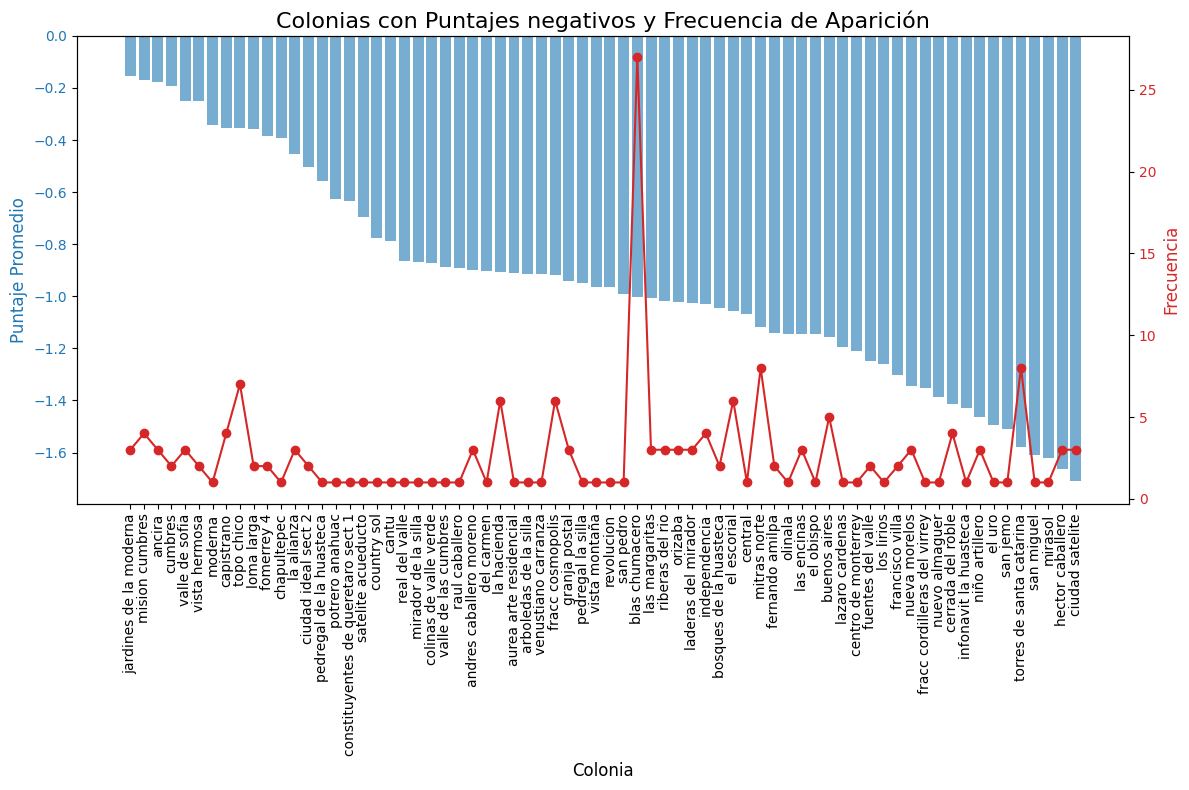

In [219]:
import matplotlib.pyplot as plt

# Agrupar por colonia y calcular el puntaje promedio y la frecuencia de aparición
puntaje_por_colonia = colonias.groupby('colonia')['Puntaje'].mean()
frecuencia_por_colonia = colonias['colonia'].value_counts()

# Filtrar colonias con puntaje promedio mayor a 0
puntaje_por_colonia = puntaje_por_colonia[puntaje_por_colonia < 0]

# Ordenar los valores de mayor a menor
puntaje_por_colonia = puntaje_por_colonia.sort_values(ascending=False)
frecuencia_por_colonia = frecuencia_por_colonia[puntaje_por_colonia.index]

# Crear un gráfico combinado
fig, ax1 = plt.subplots(figsize=(12, 8))

# Gráfico de barras para el puntaje promedio
color = 'tab:blue'
ax1.set_xlabel('Colonia', fontsize=12)
ax1.set_ylabel('Puntaje Promedio', fontsize=12, color=color)
ax1.bar(puntaje_por_colonia.index, puntaje_por_colonia.values, color=color, alpha=0.6, label='Puntaje Promedio')
ax1.tick_params(axis='y', labelcolor=color)

# Crear un segundo eje y para la frecuencia
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Frecuencia', fontsize=12, color=color)  
ax2.plot(frecuencia_por_colonia.index, frecuencia_por_colonia.values, color=color, marker='o', linestyle='-', label='Frecuencia')
ax2.tick_params(axis='y', labelcolor=color)

# Añadir título y rotar etiquetas del eje X
plt.title('Colonias con Puntajes negativos y Frecuencia de Aparición', fontsize=16)
ax1.set_xticklabels(puntaje_por_colonia.index, rotation=90)

# Mostrar el gráfico
fig.tight_layout()
plt.show()


/var/folders/8b/d34q145x44x2xf_06_gchyfw0000gq/T/ipykernel_70763/999271397.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(puntaje_por_colonia.index, rotation=90)


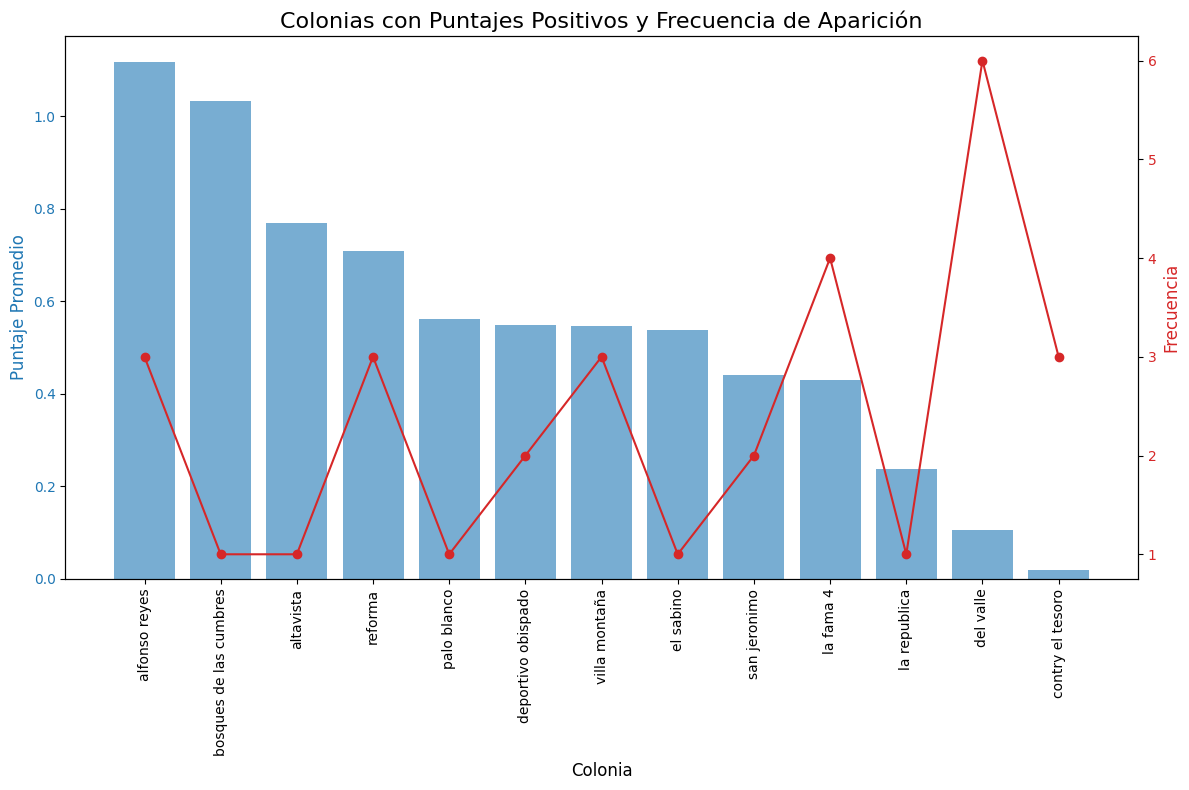

In [212]:
import matplotlib.pyplot as plt

# Agrupar por colonia y calcular el puntaje promedio y la frecuencia de aparición
puntaje_por_colonia = colonias.groupby('colonia')['Puntaje'].mean()
frecuencia_por_colonia = colonias['colonia'].value_counts()

# Filtrar colonias con puntaje promedio mayor a 0
puntaje_por_colonia = puntaje_por_colonia[puntaje_por_colonia > 0]

# Ordenar los valores de mayor a menor
puntaje_por_colonia = puntaje_por_colonia.sort_values(ascending=False)
frecuencia_por_colonia = frecuencia_por_colonia[puntaje_por_colonia.index]

# Crear un gráfico combinado
fig, ax1 = plt.subplots(figsize=(12, 8))

# Gráfico de barras para el puntaje promedio
color = 'tab:blue'
ax1.set_xlabel('Colonia', fontsize=12)
ax1.set_ylabel('Puntaje Promedio', fontsize=12, color=color)
ax1.bar(puntaje_por_colonia.index, puntaje_por_colonia.values, color=color, alpha=0.6, label='Puntaje Promedio')
ax1.tick_params(axis='y', labelcolor=color)

# Crear un segundo eje y para la frecuencia
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Frecuencia', fontsize=12, color=color)  
ax2.plot(frecuencia_por_colonia.index, frecuencia_por_colonia.values, color=color, marker='o', linestyle='-', label='Frecuencia')
ax2.tick_params(axis='y', labelcolor=color)

# Añadir título y rotar etiquetas del eje X
plt.title('Colonias con Puntajes Positivos y Frecuencia de Aparición', fontsize=16)
ax1.set_xticklabels(puntaje_por_colonia.index, rotation=90)

# Mostrar el gráfico
fig.tight_layout()
plt.show()


/var/folders/8b/d34q145x44x2xf_06_gchyfw0000gq/T/ipykernel_70763/2527652994.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(puntaje_filtrado.index, rotation=90)


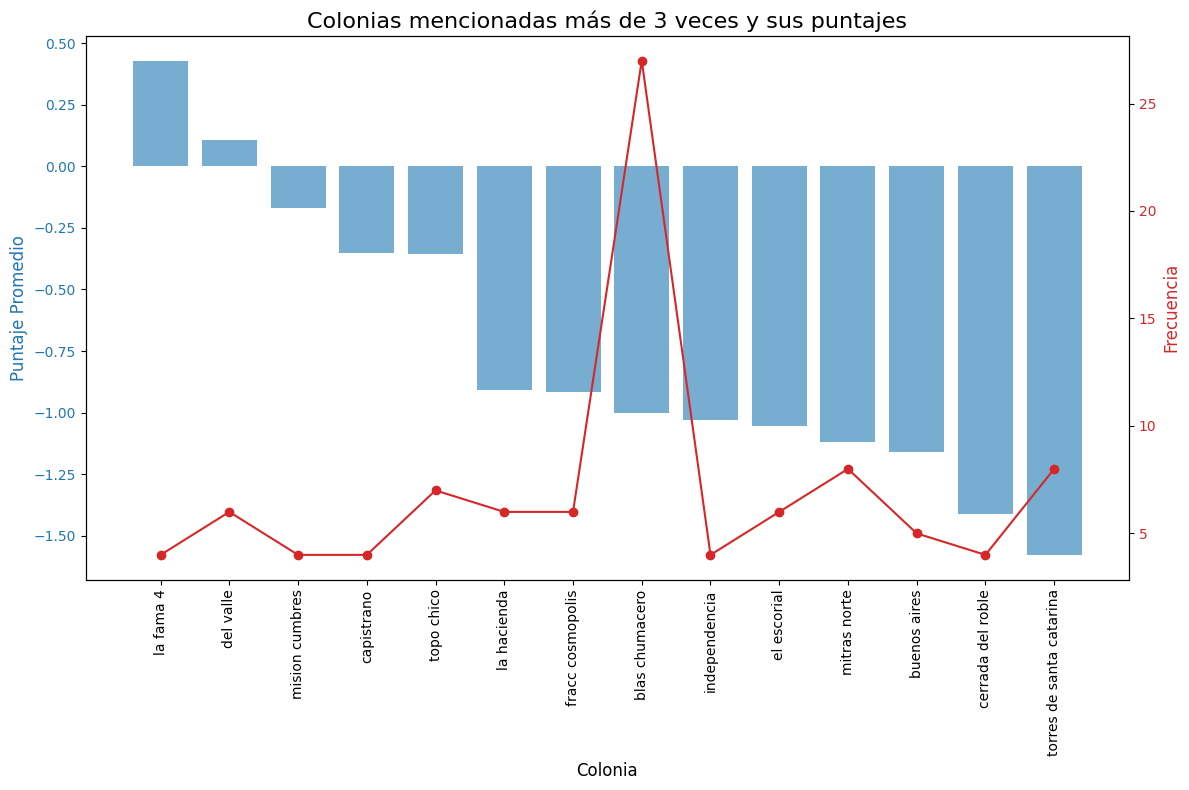

In [239]:
import matplotlib.pyplot as plt

# Agrupar por colonia y calcular el puntaje promedio y la frecuencia de aparición
puntaje_por_colonia = colonias.groupby('colonia')['Puntaje'].mean()
frecuencia_por_colonia = colonias['colonia'].value_counts()

# Filtrar colonias con puntaje promedio mayor a 0
puntaje_por_colonia = puntaje_por_colonia[puntaje_por_colonia > -2]

# Filtrar colonias con frecuencia mayor a 3
frecuencia_filtrada = frecuencia_por_colonia[frecuencia_por_colonia > 3]
puntaje_filtrado = puntaje_por_colonia[frecuencia_filtrada.index]

# Ordenar los valores de mayor a menor
puntaje_filtrado = puntaje_filtrado.sort_values(ascending=False)
frecuencia_filtrada = frecuencia_filtrada[puntaje_filtrado.index]

# Crear un gráfico combinado
fig, ax1 = plt.subplots(figsize=(12, 8))

# Gráfico de barras para el puntaje promedio
color = 'tab:blue'
ax1.set_xlabel('Colonia', fontsize=12)
ax1.set_ylabel('Puntaje Promedio', fontsize=12, color=color)
ax1.bar(puntaje_filtrado.index, puntaje_filtrado.values, color=color, alpha=0.6, label='Puntaje Promedio')
ax1.tick_params(axis='y', labelcolor=color)

# Crear un segundo eje y para la frecuencia
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Frecuencia', fontsize=12, color=color)  
ax2.plot(frecuencia_filtrada.index, frecuencia_filtrada.values, color=color, marker='o', linestyle='-', label='Frecuencia')
ax2.tick_params(axis='y', labelcolor=color)

# Añadir título y rotar etiquetas del eje X
plt.title('Colonias mencionadas más de 3 veces y sus puntajes', fontsize=16)
ax1.set_xticklabels(puntaje_filtrado.index, rotation=90)

# Mostrar el gráfico
fig.tight_layout()
plt.show()


<Figure size 1500x1000 with 0 Axes>

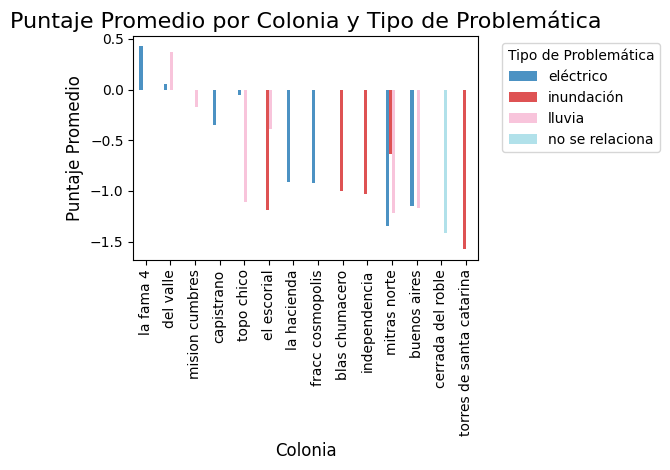

In [245]:
import matplotlib.pyplot as plt
import pandas as pd

# Agrupar por colonia y tipo de problemática para calcular el puntaje promedio
puntaje_por_colonia_tipo = colonias.groupby(['colonia', 'Tipo'])['Puntaje'].mean().unstack()

# Calcular la frecuencia de aparición por colonia (sin desglosar por tipo)
frecuencia_por_colonia = colonias['colonia'].value_counts()

# Filtrar colonias con puntaje promedio mayor a -5 (si se desea mantener valores negativos, este filtro se puede ajustar)
puntaje_por_colonia = puntaje_por_colonia_tipo.mean(axis=1)
puntaje_filtrado = puntaje_por_colonia[puntaje_por_colonia > -5]

# Filtrar colonias con frecuencia mayor a 3
frecuencia_filtrada = frecuencia_por_colonia[frecuencia_por_colonia > 3]
colonias_filtradas = puntaje_filtrado[frecuencia_filtrada.index].index

# Filtrar puntaje promedio para las colonias seleccionadas y eliminar las colonias no deseadas
puntaje_por_colonia_tipo = puntaje_por_colonia_tipo.loc[colonias_filtradas]

# Asegurarse de que los puntajes filtrados sean mayores a -2 en al menos un tipo de problemática
puntaje_por_colonia_tipo = puntaje_por_colonia_tipo.loc[(puntaje_por_colonia_tipo > -2).any(axis=1)]

# Ordenar el DataFrame por el puntaje promedio (descendente)
puntaje_por_colonia_tipo['average'] = puntaje_por_colonia_tipo.mean(axis=1)  # Añadir columna con promedio
puntaje_por_colonia_tipo = puntaje_por_colonia_tipo.sort_values(by='average', ascending=False)  # Ordenar por promedio
puntaje_por_colonia_tipo = puntaje_por_colonia_tipo.drop(columns=['average'])  # Eliminar la columna de promedio

# Crear gráfico
plt.figure(figsize=(15, 10))  # Tamaño de la figura más grande
puntaje_por_colonia_tipo.plot(kind='bar', colormap='tab20', alpha=0.8)
plt.title('Puntaje Promedio por Colonia y Tipo de Problemática', fontsize=16)
plt.xlabel('Colonia', fontsize=12)
plt.ylabel('Puntaje Promedio', fontsize=12)
plt.legend(title='Tipo de Problemática', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()  # Ajusta el diseño para que todo se vea bien
plt.show()
